<a href="https://colab.research.google.com/github/JaisSolutions/AgilePractice/blob/main/Abiola_Oluwole_work_on_GSV_preprocessing_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Growing stock volume eatimation through remote sensing data

This notebook presents the task of growing stock volume (GSV) estimation through remote sensing data. As a study area, we consider forestry in Perm Krai. The dataset was collected in 2020 using ground based measurements.

Each study plot is a circle with a fixed radius of 9m.

We use Sentinel-2 data as resource of remote sensing observations.

In [ ]:
%%capture

# install library for spatial data processing
! pip install rasterio

# install packages for spatial data mapping
! pip install folium matplotlib mapclassify

! pip install geopandas

! pip install xgboost

In [ ]:
import numpy as np
import pandas as pd


import rasterio
import tifffile as tiff
import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry import mapping
from rasterio.mask import mask
from rasterio.windows import from_bounds

import matplotlib.pyplot as plt

I downloaded data from https://disk.yandex.ru/d/yqVOed67gKPefg

In [ ]:
# I got the data, unpack it, and remove zip file
%%capture

! wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/yqVOed67gKPefg -O ./GSV_dataset.zip
! unzip ./GSV_dataset.zip
! rm -f GSV_dataset.zip

The dataset includes the following files:

*   2022.tif --- composite image of Sentinel-2 for 2022
*   2023.tif --- composite image of Sentinel-2 for 2023    
*   age.tif --- additional data with forest age estimated by ML model    
*   chm.tif --- canopy height model (chm)
*   dem.tif --- digital elevation model (dem)      
*   data.csv --- data with inventory plots' coordinates and taxation measurements for height and timber volume   

All data have. the spatial resolution of 10m per pixel and the same extention.

Satellite images have 10 spectral bands with original resolution from 10 to 20 m per pixel that were brought to 10 m presolution.

The structure of taxation data is the following: we have a set of plots with coordinates and reference data for these plots. Each plot has a radius of 9m. Therefore, each plot cover a several pixels.

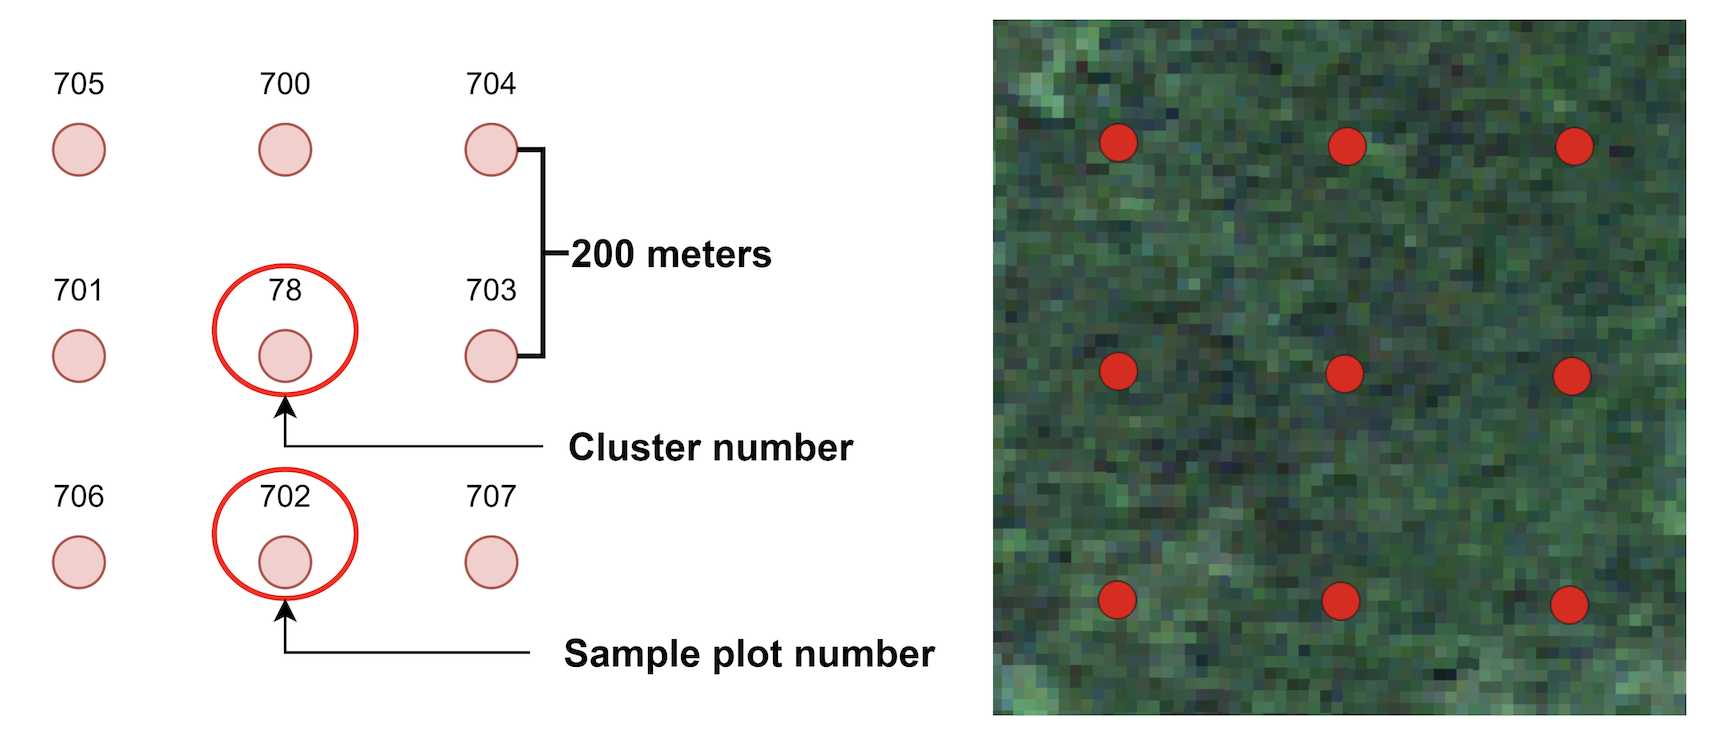

## Brief note about libraries to work with environmental raster data

Here are some TIFF details:

* TIFF stands for Tage Image File Format
* It is often used for environmental and medical imaging
* It contains metadata that can be used both for data processing and visualization in GIS systems

The most popular Python libraries to work with TIFF files are:

* <a href="https://pypi.org/project/rasterio/">rasterio</a> : this is a library that is useful for GIS processing in general
* <a href="https://pypi.org/project/tifffile/">tiffile</a> : more focused on TIFF file processing

# Code to convert data from GEE into format of Sentinel-Hub

When we download imagery from GEE, it returns 23 bands in the raster file. However, for our study, we need only 10 spectral bands with spatial resolution from 10 t0 20 m. These bands are 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'. The corresponding bands in GEE file have the following indices 1, 2, 3, 4, 5, 6, 7, 8, 10, 11

Let's read, extract channels, and write new file with the same resolution band only 10 spectral bands.

In the shared dataset images are already preprocessed, so you should skip this code.

In [ ]:
# the file name is set
file_path = 'timberstock/2022.tif'

# the path to output file is set
outputpath = '2022.tif'

# the file and meta data is read
with rasterio.open(file_path) as src:
    meta = src.meta
    image = src.read()

In [ ]:
image.shape

(10, 7200, 10000)

In [ ]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 10000,
 'height': 7200,
 'count': 10,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32640"]]'),
 'transform': Affine(10.0, 0.0, 485999.0,
        0.0, -10.0, 6804001.0)}

In [ ]:
# here is new empty image with the same resolution but 10 bands
image_new = np.zeros((10, image.shape[1], image.shape[2]), dtype='uint16')

In [ ]:
image_new.shape

(10, 7200, 10000)

In [ ]:
# we check all new indices
for ind, band in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    print(ind, band)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [ ]:
# we copy the necessary bands to new file
for ind, band in enumerate([0, 2, 3, 4, 5, 6, 7, 8, 9]):
    image_new[ind] = image[band]

In [ ]:
out_meta = meta.copy()
out_meta['count'] = 10 # change number of bands in the metadata properties
with rasterio.open(fp=outputpath, # outputpath_name
             mode='w',**out_meta) as dst:
             dst.write(image_new) # the numer one is the number of bands

# Visualize raster data

Let's open and visualize raster data with satellite images and environmental features.

In [ ]:
# read satellite composite image
with rasterio.open('timberstock/2022.tif') as src:
    meta = src.meta
    image = src.read()

# read canopy height model
with rasterio.open('timberstock/chm.tif') as src:
    chm = src.read()

# read digital elevation model
with rasterio.open('timberstock/dem.tif') as src:
    dem = src.read()

# read. forest age
with rasterio.open('timberstock/age.tif') as src:
    age = src.read()

In [ ]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 10000,
 'height': 7200,
 'count': 10,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32640"]]'),
 'transform': Affine(10.0, 0.0, 485999.0,
        0.0, -10.0, 6804001.0)}

Check the shape of each file

In [ ]:
image.shape, chm.shape, dem.shape, age.shape

((10, 7200, 10000), (1, 7200, 10000), (1, 7200, 10000), (1, 7200, 10000))

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad8696d77f0>)

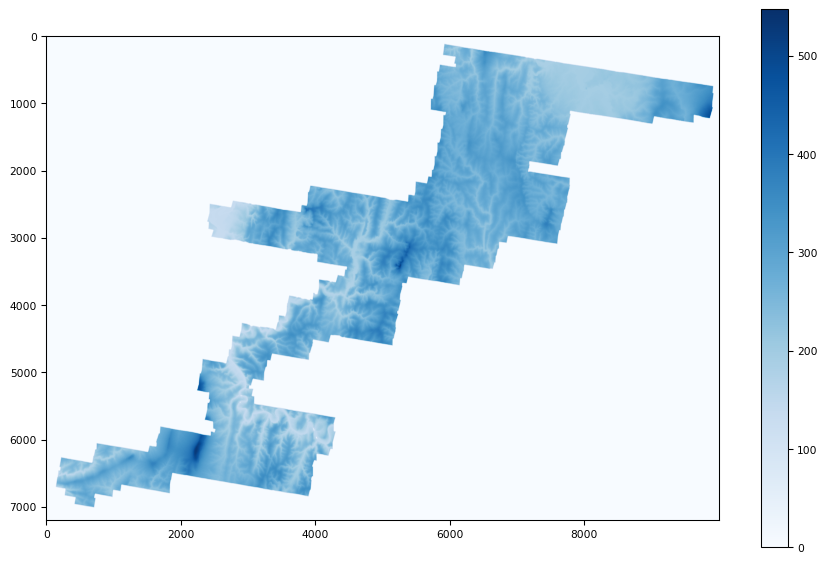

In [ ]:
tiff.imshow(dem, cmap='Blues')

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad869d965c0>)

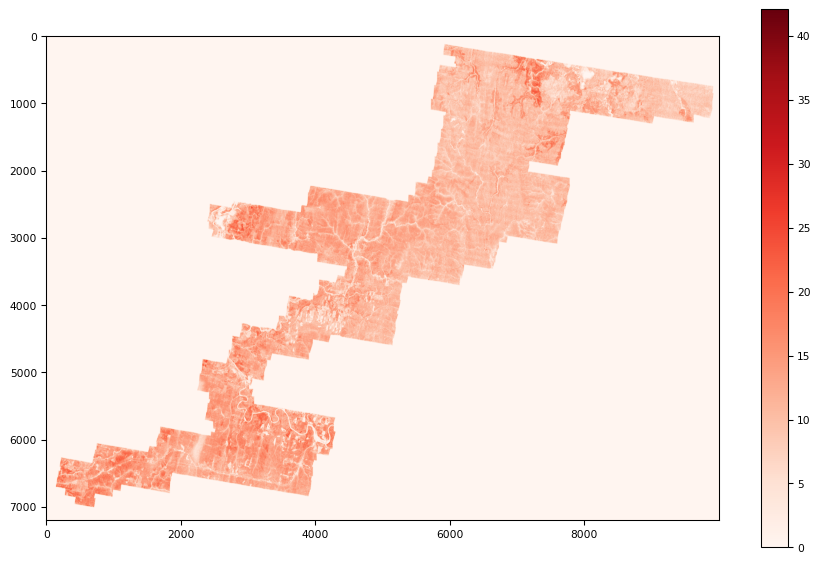

In [ ]:
tiff.imshow(chm, cmap='Reds')

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad86952c190>)

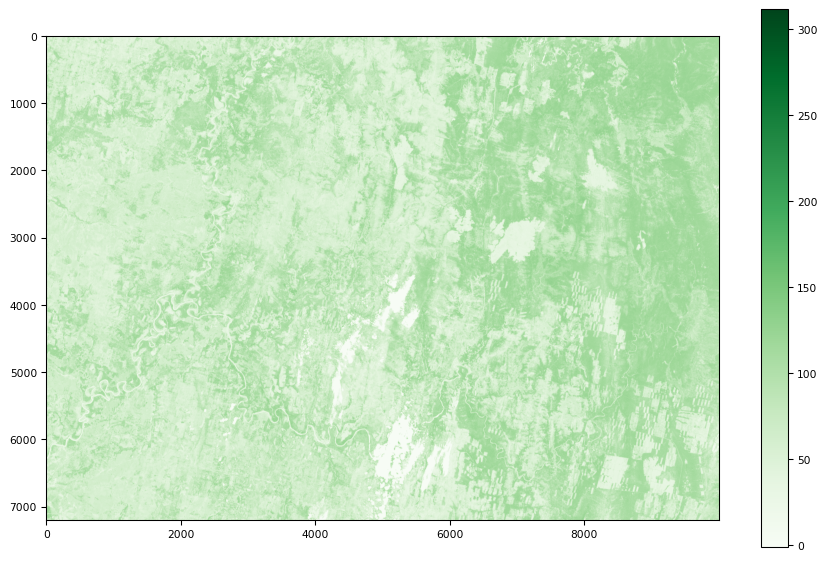

In [ ]:
tiff.imshow(age, cmap='Greens')

In [ ]:
meta['nodata']

65535.0

In [ ]:
# image = image.astype(float)
# image[image==meta['nodata']] = np.nan

In [ ]:
image = np.clip(image, 0, 1000)

(<Figure size 988.8x604.8 with 3 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad869d43e80>)

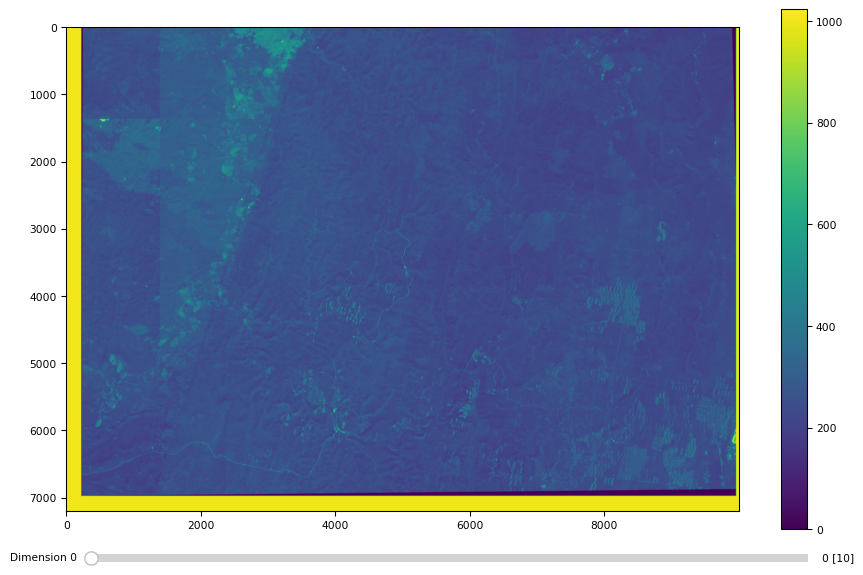

In [ ]:
tiff.imshow(image)

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad868ac2d10>)

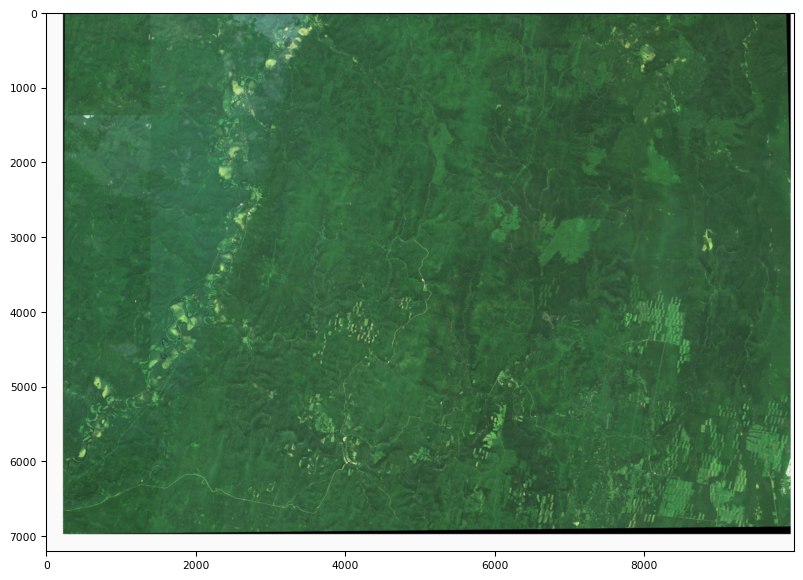

In [ ]:
tiff.imshow(np.asarray([image[2,:,:], image[1,:,:], image[0,:,:]]))

We can compute statistics for these bands

In [ ]:
stats = []

for band in image:
    stats.append({
    'min': band.min().round(3),
    'mean': band.mean().round(3),
    'median': np.median(band).round(3),
    'max': band.max().round(3)})

In [ ]:
stats

[{'min': 0, 'mean': 295.098, 'median': 248.0, 'max': 1000},
 {'min': 0, 'mean': 437.58, 'median': 403.0, 'max': 1000},
 {'min': 0, 'mean': 263.813, 'median': 215.0, 'max': 1000},
 {'min': 0, 'mean': 651.096, 'median': 631.0, 'max': 1000},
 {'min': 0, 'mean': 989.413, 'median': 1000.0, 'max': 1000},
 {'min': 0, 'mean': 989.621, 'median': 1000.0, 'max': 1000},
 {'min': 0, 'mean': 989.22, 'median': 1000.0, 'max': 1000},
 {'min': 0, 'mean': 989.596, 'median': 1000.0, 'max': 1000},
 {'min': 0, 'mean': 955.646, 'median': 1000.0, 'max': 1000},
 {'min': 0, 'mean': 532.55, 'median': 500.0, 'max': 1000}]

We then merge all raster bands to create a single feature space. The shape os a new raster will be 10 spactral bands + chm + dem + age. Totally, we will obtain 13 bands:

'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'CHM', 'DEM', 'AGE'

with rasterio.open('timberstock/2022.tif') as src: # composite Sentinel-2 for 2023
    meta = src.meta
    image = src.read() # 10 bands

with rasterio.open('timberstock/chm.tif') as src: # canopy height model - height
    chm = src.read()

with rasterio.open('timberstock/dem.tif') as src:
    dem = src.read()

with rasterio.open('timberstock/age.tif') as src:
    age = src.read()

result_img = np.concatenate((image, chm, dem, age), axis=0)

In [ ]:
with rasterio.open('timberstock/2022.tif') as src: # composite Sentinel-2 for 2023
    meta = src.meta
    image = src.read() # 10 bands

with rasterio.open('timberstock/chm.tif') as src: # canopy height model - height
    chm = src.read()

with rasterio.open('timberstock/dem.tif') as src:
    dem = src.read()

with rasterio.open('timberstock/age.tif') as src:
    age = src.read()

result_img = np.concatenate((image, chm, dem, age), axis=0)

In [ ]:
outputpath = 'merged_data.tif'
out_meta = meta.copy()
out_meta['count'] = 13 # change number of bands in the metadata properties
with rasterio.open(fp=outputpath,
             mode='w',**out_meta) as dst:
             dst.write(result_img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad8699eec50>)

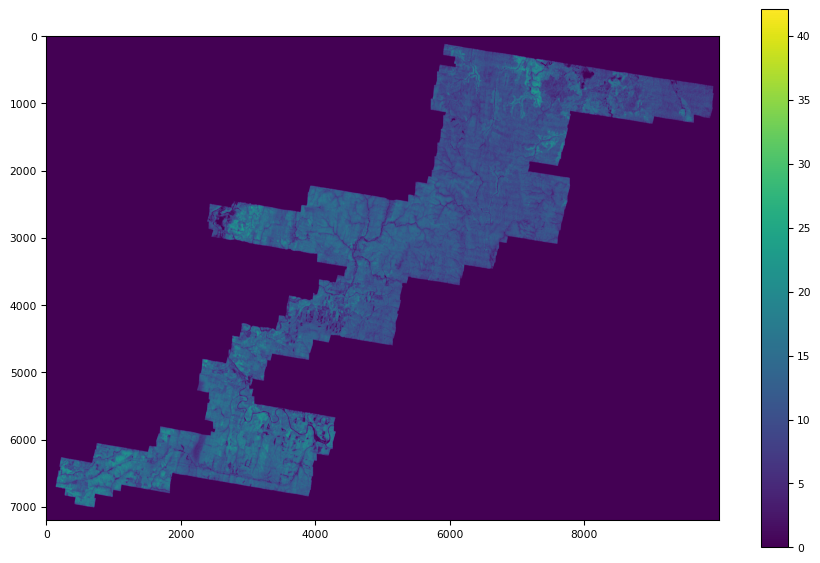

In [ ]:
tiff.imshow(result_img[-3, :, :])

In [ ]:
merged_img_path = 'merged_data.tif'
with rasterio.open(merged_img_path) as src:
    meta = src.meta
    image = src.read()

In [ ]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 10000,
 'height': 7200,
 'count': 13,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32640"]]'),
 'transform': Affine(10.0, 0.0, 485999.0,
        0.0, -10.0, 6804001.0)}

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ad8699042e0>)

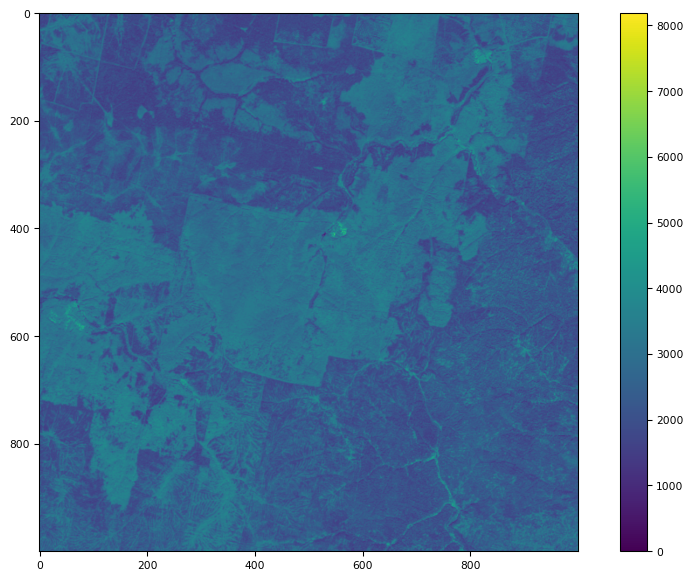

In [ ]:
tiff.imshow(image[6, 1000:2000, 1000:2000])

In [ ]:
np.max(image)

65535

In [ ]:
meta['crs']

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32640"]]')

# Create dataset in CSV format

We can read csv file with taxation data. It contains coordinates in format of latitude (y), and longitude (x). The projection of this data is crs='EPSG:32640'. Field based measurements contain timber volume and forest height.

In [ ]:
# specify path and read vector polygon shapefile

df_path = 'timberstock/data.csv'
df = pd.read_csv(df_path)
df.head()

y           x    V     H
0  6745060.540  526642.170  360  22.0
1  6743223.665  526509.015  215  24.3
2  6742455.950  525509.350  514  24.0
3  6740124.512  522847.614  319  19.3
4  6739308.912  524661.734  267  17.8

In [ ]:
print(df.size)

3672


In [ ]:
print(df.shape)

(918, 4)


Now let's create geo pandas dataframe to process coordinates into georeferenced data, so then we can create polygons.

GeoPandas is based on the pandas. It extends pandas data types to include geometry columns and perform spatial operations.

The main data structure in GeoPandas is the GeoDataFrame that extends the pandas DataFrame. So all the base DataFrame operations can be performed on the GeoDataFrame. The GeoDataFrame contains one or more GeoSeries (that extends pandas Series) each of which contains geometries in a different projection (GeoSeries.crs).

Here is the link for the documentation for [geopandas](https://geopandas.org/en/stable/).

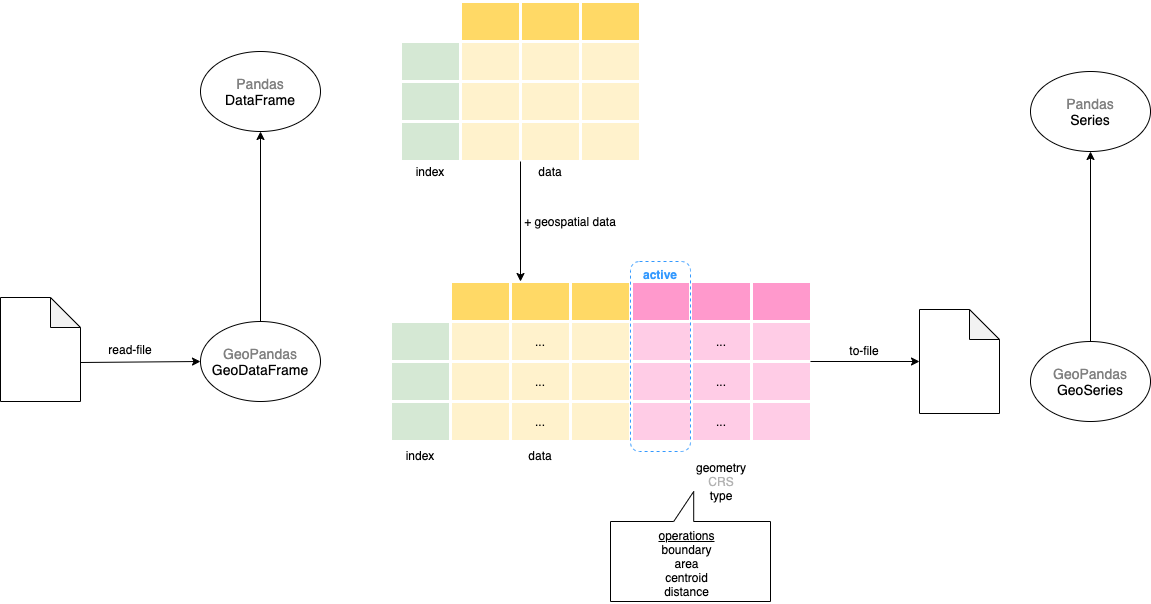

Here we convert points of latitude and longitude into points

In [ ]:
geometry = [Point(lon, lat) for lon, lat in zip(df['x'], df['y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:32640')
gdf.head()

y           x    V     H                        geometry
0  6745060.540  526642.170  360  22.0    POINT (526642.17 6745060.54)
1  6743223.665  526509.015  215  24.3  POINT (526509.015 6743223.665)
2  6742455.950  525509.350  514  24.0    POINT (525509.35 6742455.95)
3  6740124.512  522847.614  319  19.3  POINT (522847.614 6740124.512)
4  6739308.912  524661.734  267  17.8  POINT (524661.734 6739308.912)

In [ ]:
print(gdf.dtypes)

y            float64
x            float64
V              int64
H            float64
geometry    geometry
dtype: object


We can now visualize spatial distribution of taxation plots in the georefernces map

In [ ]:
gdf.explore()

In [ ]:
# code to save map

# m = gdf.explore()
# outfp = r"<your dir path>\base_map.html"
# m.save(outfp)

We set buffer distance to 9m and update geometry with new shapes, namely the POLYGON format

In [ ]:
buffer_distance = 9  # radius in meters
gdf.geometry = gdf.buffer(buffer_distance)

In [ ]:
gdf.to_file('dataframe.geojson', driver='GeoJSON')

In [ ]:
gdf.head()

y           x    V     H  \
0  6745060.540  526642.170  360  22.0   
1  6743223.665  526509.015  215  24.3   
2  6742455.950  525509.350  514  24.0   
3  6740124.512  522847.614  319  19.3   
4  6739308.912  524661.734  267  17.8   

                                            geometry  
0  POLYGON ((526651.17 6745060.54, 526651.127 674...  
1  POLYGON ((526518.015 6743223.665, 526517.972 6...  
2  POLYGON ((525518.35 6742455.95, 525518.307 674...  
3  POLYGON ((522856.614 6740124.512, 522856.571 6...  
4  POLYGON ((524670.734 6739308.912, 524670.691 6...

In [ ]:
gdf.explore()

<Axes: >

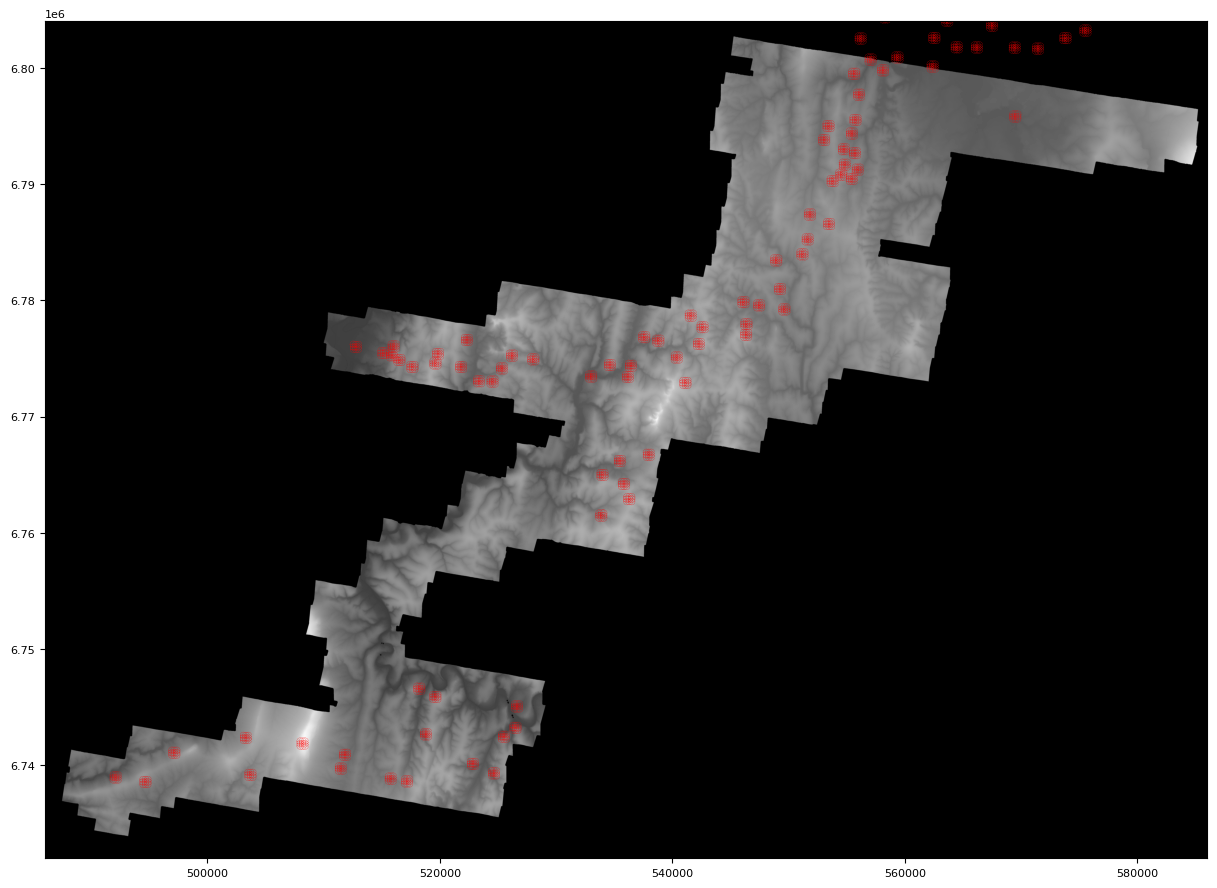

In [ ]:
from rasterio.plot import show

ax = gdf.boundary.plot(color="red", figsize=(15,15), linewidth=5)

demfile = "timberstock/dem.tif" #r"merged_data.tif"
src = rasterio.open(demfile)
show(src, cmap="gray", ax=ax)

In [ ]:
# tmp = np.zeros((10, 25, 25), dtype='uint16')
# tmp1 = tmp.reshape(10, -1)
# tmp1.shape

To create features for our dataset, we will calculate the following statistics for each inventory plot:

* min,
* max,
* mean,
* median,
* std

Let's create the header for dataframe with all combinations of these statistics and bands' values in the merged image  

In [ ]:
combinations = []
cols = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'CHM', 'DEM', 'AGE']
agg_t = ['min', 'max', 'mean', 'median', 'std']
# Generate combinations
for agg in agg_t:
    for col in cols:
        combinations.append(f"{col}_{agg}")

combinations.append(f"lon") # add header for coordinates
combinations.append(f"lat") # add header for coordinates
combinations.append(f"V") # add the target with timber volume
result_df = pd.DataFrame(columns=combinations)

In [ ]:
result_df

Empty DataFrame
Columns: [B02_min, B03_min, B04_min, B05_min, B06_min, B07_min, B08_min, B8A_min, B11_min, B12_min, CHM_min, DEM_min, AGE_min, B02_max, B03_max, B04_max, B05_max, B06_max, B07_max, B08_max, B8A_max, B11_max, B12_max, CHM_max, DEM_max, AGE_max, B02_mean, B03_mean, B04_mean, B05_mean, B06_mean, B07_mean, B08_mean, B8A_mean, B11_mean, B12_mean, CHM_mean, DEM_mean, AGE_mean, B02_median, B03_median, B04_median, B05_median, B06_median, B07_median, B08_median, B8A_median, B11_median, B12_median, CHM_median, DEM_median, AGE_median, B02_std, B03_std, B04_std, B05_std, B06_std, B07_std, B08_std, B8A_std, B11_std, B12_std, CHM_std, DEM_std, AGE_std, lon, lat, V]
Index: []

[0 rows x 68 columns]

Let's fill the dataframe with computed values for each individual plot.

In [ ]:
%%capture
merged_img_path = 'merged_data.tif' # raster with all spatial features

with rasterio.open(merged_img_path) as src:

    for geometry, lon, lat, vol in zip(gdf.geometry, gdf['x'], gdf['y'], gdf['V']):

        x_list, y_list = geometry.exterior.xy # latitude (y), and longitude (x)

        left = np.min(x_list)
        bottom = np.min(y_list)
        right = np.max(x_list)
        top = np.max(y_list)
        cropped_image = src.read(window=from_bounds(left, bottom, right, top, src.transform))

        row, col = src.index(lon, lat)
        feature_vec = cropped_image.reshape(13, -1)
        feature_vec = feature_vec.astype('float')
        feature_vec[feature_vec == 0] = np.nan

        if feature_vec.size == 0: # is zero-size array
            continue
        nanmin = np.nanmin(feature_vec, axis=1)
        nanmax = np.nanmax(feature_vec, axis=1)
        nanmean = np.nanmean(feature_vec, axis=1)
        nanmedian = np.nanmedian(feature_vec, axis=1)
        nanstd = np.nanstd(feature_vec, axis=1)
        merged_array = np.concatenate((nanmin, nanmax, nanmean,
                                        nanmedian, nanstd,
                                        [lon, lat, vol]))
        tmp = pd.DataFrame([merged_array], columns=combinations)
        result_df = pd.concat([result_df, tmp])

In [ ]:
result_df.dropna(inplace=True)

In [ ]:
print('Number of plots after drop nan values: ', len(result_df), ', number of all plots: ', len(gdf.geometry))

Number of plots after drop nan values:  686 , number of all plots:  918


In [ ]:
result_df

B02_min  B03_min  B04_min  B05_min  B06_min  B07_min  B08_min  B8A_min  \
0     240.0    385.0    227.0    612.0   1799.0   2185.0   2032.0   2343.0   
0     226.0    343.0    199.0    539.0   1635.0   2012.0   1819.0   2091.0   
0     235.0    356.0    190.0    536.0   1512.0   1833.0   1839.0   2038.0   
0     227.0    400.0    205.0    636.0   2231.0   2801.0   2852.0   3015.0   
0     245.0    393.0    204.0    656.0   2109.0   2655.0   2466.0   2824.0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
0     266.0    452.0    278.0    739.0   1857.0   2140.0   2132.0   2309.0   
0     273.0    453.0    279.0    734.0   1919.0   2226.0   2118.0   2370.0   
0     224.0    366.0    207.0    575.0   1569.0   1879.0   1823.0   2002.0   
0     252.0    436.0    272.0    670.0   1741.0   2107.0   2077.0   2288.0   
0     269.0    443.0    275.0    686.0   1736.0   2005.0   2102.0   2153.0   

    B11_min  B12_min  ...     B08_std     B8A_std    B11_std    B12_std  \
0    1077.0    495.0  ...  148.711760   47.399895  33.327916  12.031209   
0     868.0    406.0  ...  108.674974   64.000000  27.000000   2.000000   
0     915.0    397.0  ...  104.000000    0.000000   0.000000   0.000000   
0    1222.0    529.0  ...  196.320370   40.000000  24.000000   3.000000   
0    1185.0    522.0  ...  355.123218  283.500000  71.000000  23.000000   
..      ...      ...  ...         ...         ...        ...        ...   
0    1232.0    620.0  ...   36.113536   22.000000   8.500000   3.500000   
0    1270.0    632.0  ...  101.532015   13.500000   2.500000  12.500000   
0    1024.0    487.0  ...   42.792377   34.500000  24.000000   6.500000   
0    1097.0    548.0  ...   46.724592    0.000000   0.000000   0.000000   
0    1255.0    624.0  ...  139.389741  108.000000  17.500000   8.000000   

     CHM_std   DEM_std    AGE_std         lon          lat      V  
0   2.828427  1.000000   4.866981  526642.170  6745060.540  360.0  
0   6.128259  1.581139   6.422616  526509.015  6743223.665  215.0  
0   1.500000  0.500000   9.000000  525509.350  6742455.950  514.0  
0   1.920286  0.433013   3.082207  522847.614  6740124.512  319.0  
0   1.299038  1.118034  16.976086  524661.734  6739308.912  267.0  
..       ...       ...        ...         ...          ...    ...  
0   1.000000  0.000000   2.772634  569703.140  6796007.509  114.0  
0   4.242641  0.000000   1.479020  569302.622  6795809.739  204.0  
0   4.921608  0.000000   6.595453  569303.010  6795609.509  121.0  
0   3.091206  0.000000   1.870829  569504.768  6795607.902  156.0  
0   2.624669  0.000000   3.269174  569702.852  6795608.098  130.0  

[686 rows x 68 columns]

In [ ]:
def calculate_ndvi(b08, b04):
    return (b08 - b04) / (b08 + b04)

def calculate_evi(b08, b04, b02):
    return 2.5 * (b08 - b04) / (b08 + 6 * b04 - 7.5 * b02 + 1)

# Calculate NDVI
# for stat in ['min', 'max', 'sum', 'mean', 'median', 'std', 'var']:
#     result_df[f'NDVI_{stat}'] = calculate_ndvi(result_df[f'B08_{stat}'], result_df[f'B04_{stat}'])

# # Calculate EVI
# for stat in ['min', 'max', 'sum', 'mean', 'median', 'std', 'var']:
#     result_df[f'EVI_{stat}'] = calculate_evi(result_df[f'B08_{stat}'], result_df[f'B04_{stat}'], result_df[f'B02_{stat}'])

In [ ]:
out_path = 'train_polygon.csv'
result_df.to_csv(out_path, index=False)

# Data analysis

<Axes: ylabel='Density'>

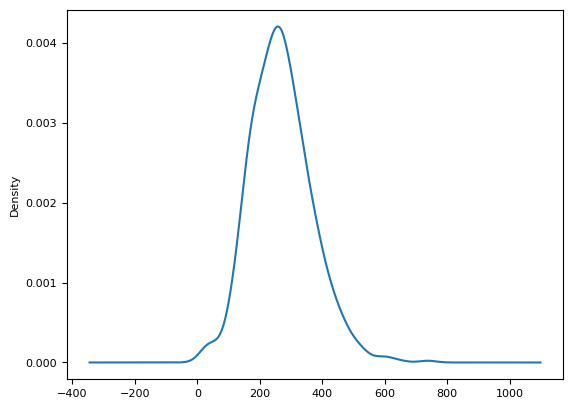

In [ ]:
result_df['V'].plot.kde()

<Axes: ylabel='Frequency'>

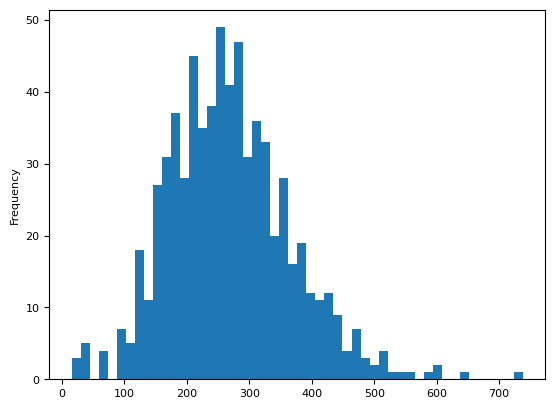

In [ ]:
result_df['V'].plot.hist(bins=50)

In [ ]:
np.sum(result_df['B04_std'])

5931.116747319018

<Axes: ylabel='Frequency'>

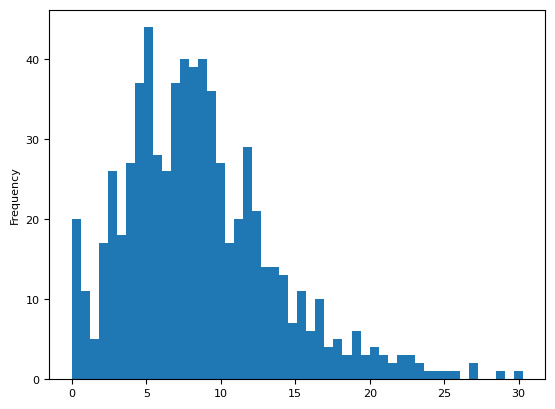

In [ ]:
result_df['B04_std'].plot.hist(bins=50)

In [ ]:
selected_columns = [item for item in combinations if ('min' in item) or ('median' in item) or ('std' in item)]

In [ ]:
selected_columns

['B02_min',
 'B03_min',
 'B04_min',
 'B05_min',
 'B06_min',
 'B07_min',
 'B08_min',
 'B8A_min',
 'B11_min',
 'B12_min',
 'CHM_min',
 'DEM_min',
 'AGE_min',
 'B02_median',
 'B03_median',
 'B04_median',
 'B05_median',
 'B06_median',
 'B07_median',
 'B08_median',
 'B8A_median',
 'B11_median',
 'B12_median',
 'CHM_median',
 'DEM_median',
 'AGE_median',
 'B02_std',
 'B03_std',
 'B04_std',
 'B05_std',
 'B06_std',
 'B07_std',
 'B08_std',
 'B8A_std',
 'B11_std',
 'B12_std',
 'CHM_std',
 'DEM_std',
 'AGE_std']

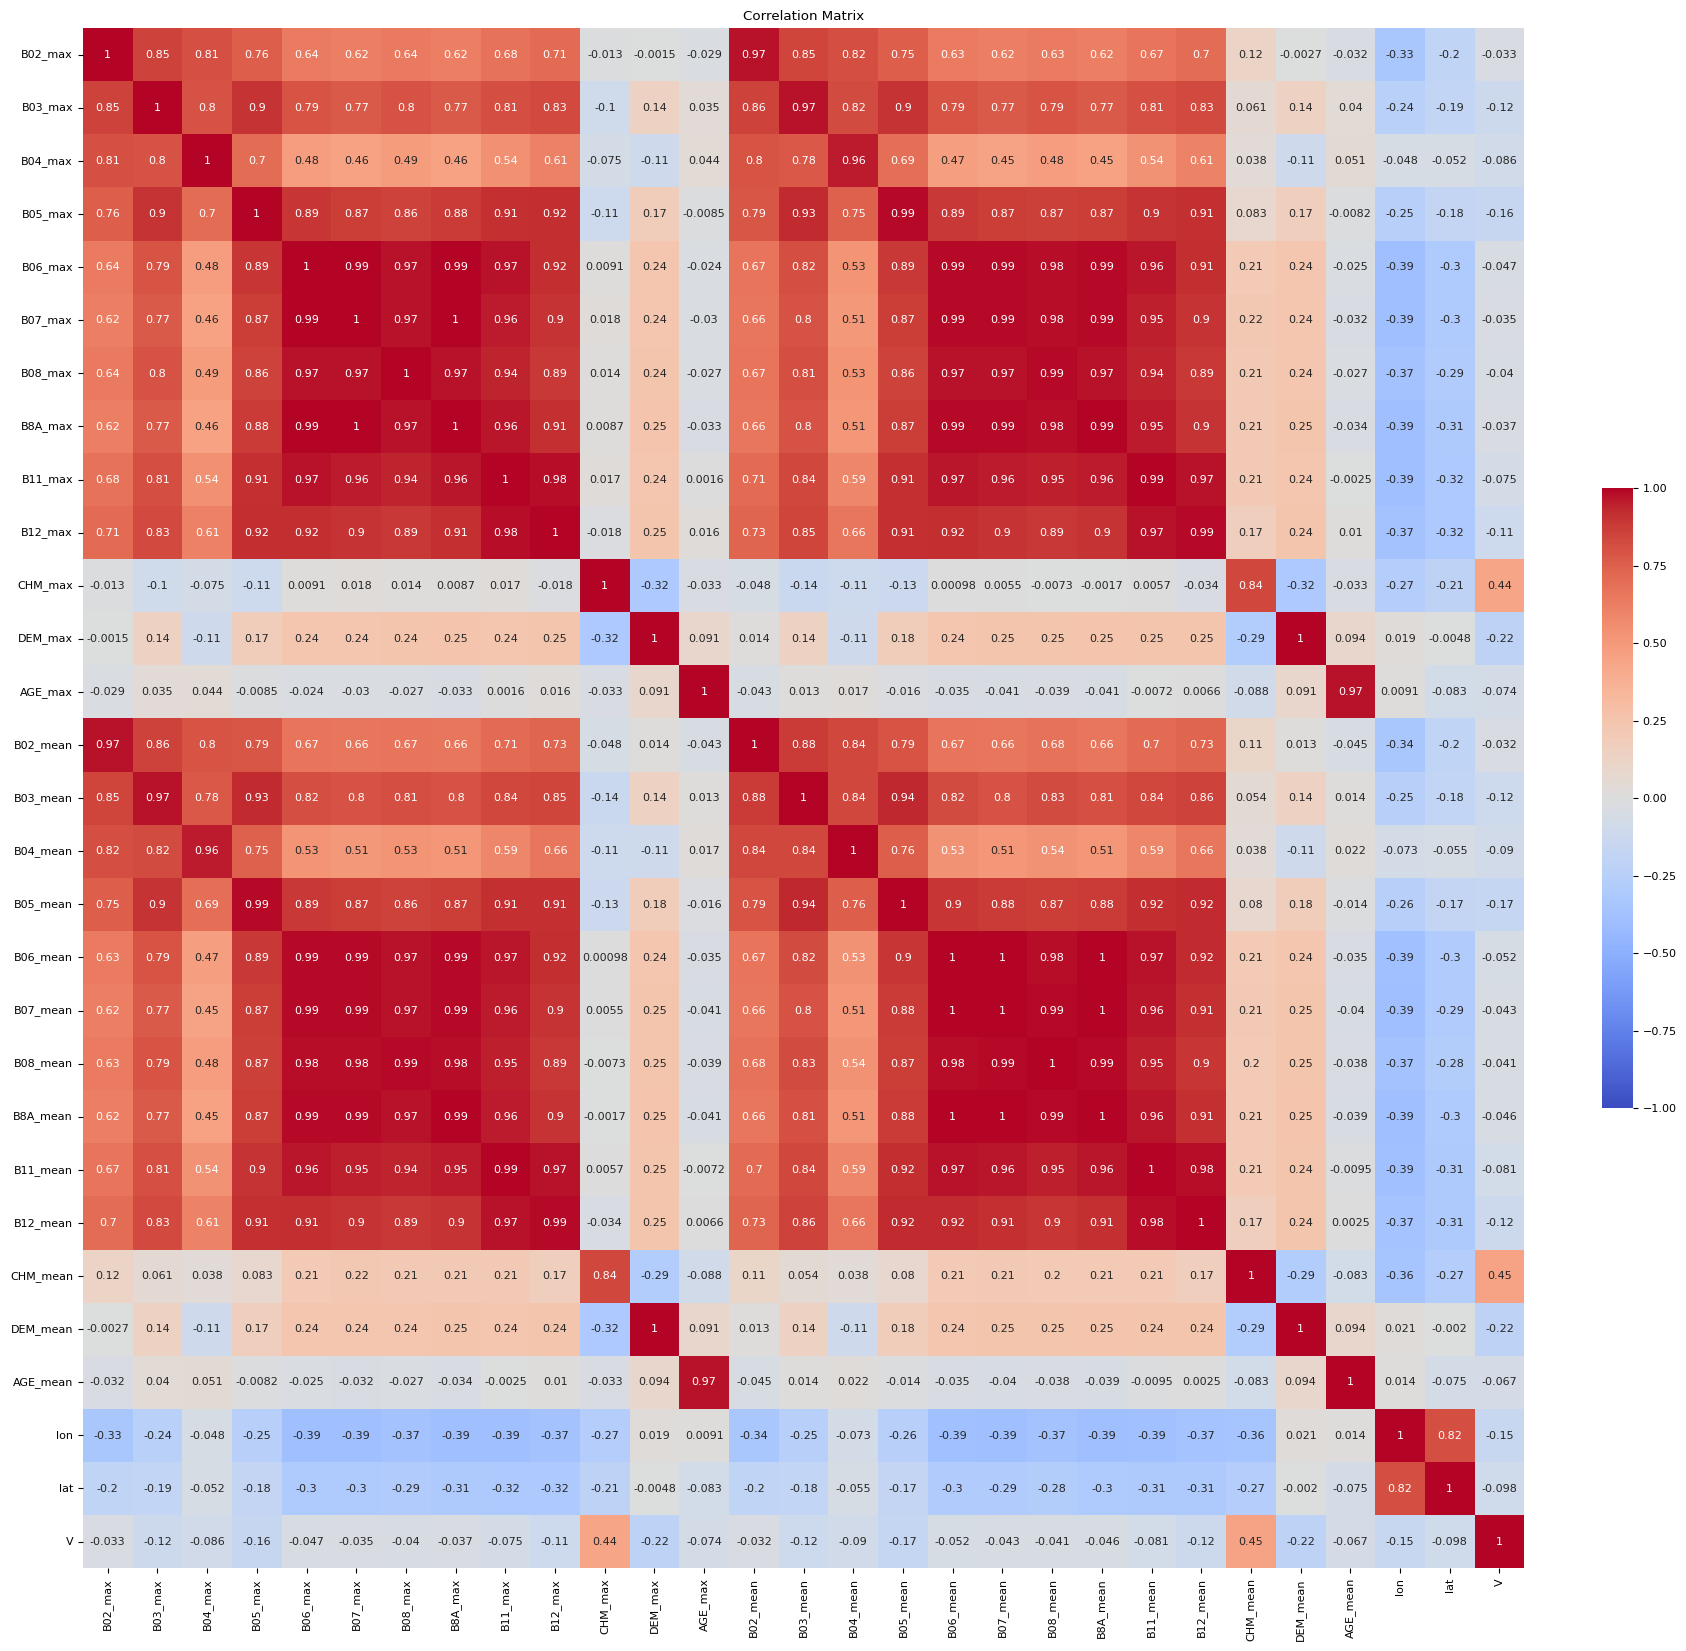

In [ ]:
import seaborn as sns

df_corr = result_df.copy()
df_corr = df_corr.drop(columns=selected_columns)
df_corr = df_corr.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True, cbar_kws={"fraction": 0.02})
plt.title('Correlation Matrix')
plt.show()

## Train model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

In [ ]:
csv_name = 'train_polygon.csv' #'dataset.csv'
dataset = pd.read_csv(csv_name, header=0)

In [ ]:
np.random.seed(0)
dataset = dataset.iloc[np.random.permutation(len(dataset))] # shuffle
df_train = dataset[0:int(2*len(dataset)//3)]
df_test = dataset[int(2*len(dataset)//3):]

print('train: ', len(df_train), 'test: ', len(df_test))

# drop target value from features data
y_train = df_train['V']
X_train = df_train.drop(['V'], axis=1)

y_test = df_test['V']
X_test = df_test.drop(['V'], axis=1)

train:  457 test:  229


In [ ]:
y_train

593    184.0
638    223.0
634    289.0
404    261.0
635    131.0
       ...  
462    301.0
681    114.0
572    126.0
546    316.0
176     36.0
Name: V, Length: 457, dtype: float64

In [ ]:
X_train

B02_min  B03_min  B04_min  B05_min  B06_min  B07_min  B08_min  B8A_min  \
593    197.0    323.0    180.0    480.0   1400.0   1718.0   1632.0   1841.0   
638    203.0    295.0    168.0    481.0   1305.0   1546.0   1532.0   1728.0   
634    211.0    323.0    189.0    480.0   1395.0   1665.0   1742.0   1791.0   
404    250.0    413.0    214.0    653.0   2015.0   2387.0   2194.0   2618.0   
635    214.0    308.0    181.0    504.0   1380.0   1665.0   1676.0   1832.0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
462    228.0    372.0    190.0    611.0   2188.0   2713.0   2498.0   2844.0   
681    266.0    452.0    278.0    739.0   1857.0   2140.0   2132.0   2309.0   
572    205.0    319.0    182.0    548.0   1497.0   1745.0   1714.0   1890.0   
546    197.0    312.0    193.0    464.0   1407.0   1648.0   1682.0   1823.0   
176    240.0    410.0    200.0    802.0   2543.0   2970.0   2867.0   3355.0   

     B11_min  B12_min  ...     B07_std     B08_std     B8A_std    B11_std  \
593    805.0    377.0  ...   30.743902   81.197291   34.142166  12.186058   
638    802.0    384.0  ...   29.500000   24.159625    7.500000  15.000000   
634    775.0    365.0  ...   61.500000   65.622024   57.000000  51.000000   
404   1101.0    486.0  ...    0.000000  249.229187    0.000000   0.000000   
635    819.0    368.0  ...   40.000000  141.335372   30.000000   7.500000   
..       ...      ...  ...         ...         ...         ...        ...   
462   1263.0    538.0  ...  135.949439  281.213442  206.535711  43.320751   
681   1232.0    620.0  ...   19.000000   36.113536   22.000000   8.500000   
572    876.0    405.0  ...   25.000000   68.363002   20.000000   2.500000   
546    828.0    399.0  ...   66.500000   90.717625   75.000000  25.000000   
176   1549.0    679.0  ...  109.500000  120.500000    5.000000   3.500000   

       B12_std   CHM_std   DEM_std   AGE_std         lon          lat  
593   6.015605  6.649979  0.433013  6.324555  555037.070  6791462.131  
638  10.500000  4.000000  0.433013  3.201562  555244.970  6794144.450  
634  22.000000  4.205651  0.000000  4.264681  555244.810  6794544.270  
404   0.000000  2.867442  0.707107  3.031089  514949.790  6775654.150  
635   9.000000  5.678908  0.000000  4.847680  555445.350  6794542.650  
..         ...       ...       ...       ...         ...          ...  
462  21.040140  3.041381  0.000000  7.224092  542803.151  6777883.776  
681   3.500000  1.000000  0.000000  2.772634  569703.140  6796007.509  
572   2.500000  2.494438  0.000000  4.527693  554535.974  6791007.895  
546   2.500000  1.500000  0.000000  4.031129  551845.810  6785041.230  
176  12.500000  0.500000  0.000000  1.500000  508393.890  6741864.730  

[457 rows x 67 columns]

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(X_train, y_train)

pred = decision_tree.predict(X_test)
print('MAPE: ', round(mean_absolute_percentage_error(y_test, pred), 3))
print('MAE: ', round(mean_absolute_error(y_test, pred), 3))

MAPE:  0.354
MAE:  66.323


[Text(0.5, 0.875, 'x[23] <= 16.5\nsquared_error = 9746.828\nsamples = 457\nvalue = 269.923'),
 Text(0.25, 0.625, 'x[42] <= 701.0\nsquared_error = 6264.469\nsamples = 199\nvalue = 225.543'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[38] <= 92.75\nsquared_error = 5652.759\nsamples = 135\nvalue = 247.067'),
 Text(0.0625, 0.125, 'squared_error = 4854.444\nsamples = 83\nvalue = 271.036'),
 Text(0.1875, 0.125, 'squared_error = 4546.194\nsamples = 52\nvalue = 208.808'),
 Text(0.375, 0.375, 'x[49] <= 11.25\nsquared_error = 4516.215\nsamples = 64\nvalue = 180.141'),
 Text(0.3125, 0.125, 'squared_error = 4461.523\nsamples = 22\nvalue = 129.5'),
 Text(0.4375, 0.125, 'squared_error = 2497.937\nsamples = 42\nvalue = 206.667'),
 Text(0.75, 0.625, 'x[36] <= 17.875\nsquared_error = 9741.805\nsamples = 258\nvalue = 304.155'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[8] <= 736.0\nsquared_error = 7784.562\nsamples = 172\nvalue = 284.384'),
 Text(0.5625, 0.125, 'squared_error = 276

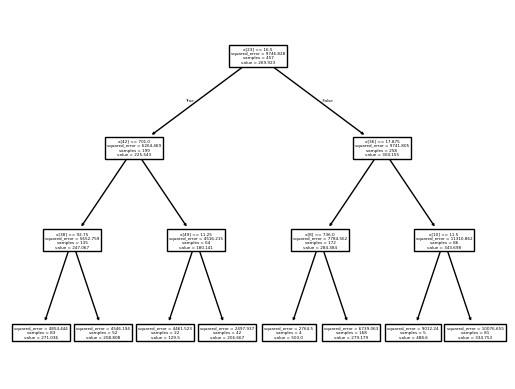

In [ ]:
 from sklearn import tree
 tree.plot_tree(decision_tree)

In [ ]:
y_test

605    115.0
372    206.0
168    217.0
347    305.0
376    263.0
       ...  
359    320.0
192    157.0
629    334.0
559    255.0
684    156.0
Name: V, Length: 229, dtype: float64

In [ ]:
pred

array([129.5       , 279.17857143, 206.66666667, 271.03614458,
       279.17857143, 208.80769231, 129.5       , 208.80769231,
       271.03614458, 279.17857143, 334.75308642, 271.03614458,
       208.80769231, 279.17857143, 279.17857143, 279.17857143,
       279.17857143, 206.66666667, 279.17857143, 129.5       ,
       208.80769231, 279.17857143, 334.75308642, 279.17857143,
       271.03614458, 334.75308642, 271.03614458, 271.03614458,
       129.5       , 271.03614458, 279.17857143, 279.17857143,
       208.80769231, 334.75308642, 206.66666667, 279.17857143,
       279.17857143, 334.75308642, 334.75308642, 271.03614458,
       279.17857143, 129.5       , 279.17857143, 271.03614458,
       129.5       , 279.17857143, 279.17857143, 503.        ,
       279.17857143, 334.75308642, 334.75308642, 279.17857143,
       279.17857143, 206.66666667, 208.80769231, 208.80769231,
       208.80769231, 279.17857143, 334.75308642, 279.17857143,
       279.17857143, 503.        , 271.03614458, 279.17

Let's try to add cross validation. Please refere to https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html